<a href="https://colab.research.google.com/github/SonDaYeong/Project1/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 게임 회사 데이터 분석
#### Golas : 다음 분기에 어떤 게임을 설계해야할까
1. 지역에 따라 선호하는 게임 장르가 다를까
2. 연도별 게임의 트렌드가 있을까
3. 출고량이 높은 게임에 대한 분석 및 시각화

- Dataset
  - Name : 게임의 이름
  - Platform : 게임이 지원되는 플랫폼의 이름
  - Year : 게임이 출시된 연도
  - Genre : 게임의 장르
  - Publisher : 게임을 제작한 회사
  - NA_Sales : 북미지역에서의 출고량
  - EU_Sales : 유럽지역에서의 출고량
  - JP_Sales : 일본지역에서의 출고량
  - Other_Sales : 기타지역에서의 출고량



#### 데이터 불러오기

In [2]:
# 사용 라브러리
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 데이터 불러오기
url = "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv"
df = pd.read_csv(url)
df = df.iloc[:,1:] 
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [4]:
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [5]:
df.select_dtypes('object').describe()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16598,16598,16548,16540,16598,16598,16598,16598
unique,11493,31,12,578,494,363,282,190
top,Need for Speed: Most Wanted,DS,Action,Electronic Arts,0,0,0,0
freq,12,2163,3305,1351,4443,5665,10333,6386


#### Preprocessing

##### 1. 결측치 처리
- Year : 크롤링을 통해 넣어줌
- Genre / Publisher 는 추후 처리 방안 확인

In [5]:
# # 출시일 크롤링

# import requests
# from bs4 import BeautifulSoup
# import time

# def getPageString(url, keywords):
#   url = url + keywords
  
#   data = requests.get(url, headers=header)
#   return data.text

# header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36'}
# url = 'https://www.google.com/search?q='

# names = df.loc[df["Year"].isnull() > 0,:]["Name"].to_list()
# result = dict()

# for idx,name in enumerate(names):
#   res = getPageString(url,name)
#   soup = BeautifulSoup(res, 'lxml')
#   time.sleep(3)
#   date = soup.select_one('div > span.LrzXr.kno-fv.wHYlTd.z8gr9e')
#   if date:
#     result[idx] = [name,date.text]
#   else:
#     result[idx] = [name,None]


In [6]:
# # 나중에 사용할 수 있어 데이터 저장해두기
# pd.DataFrame(result.items(),
#              columns=['idx','result']).to_csv("/content/drive/MyDrive/Colab Notebooks/codestates/Year_Crawling.csv",
#              sep=',')

In [7]:
## drive에 저장된 데이터 불러오기
import ast  # 문자로 되어있는 리스트를 리스트 형태로 변환시켜주는 라이브러리
result = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/codestates/Year_Crawling.csv")
result = result.iloc[:,1:]

crawl = result
crawl['result'] = crawl['result'].apply(lambda x: ast.literal_eval(x))
crawl['Name'] = crawl['result'].apply(lambda x: x[0])
crawl['Year'] = crawl['result'].apply(lambda x: x[1])

In [8]:

month = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
join_month = '|'.join(month)         

def check_month(x):
  if x != None:
    if x.split(" ")[0] in month:
      return x.split(", ")[1][:4]
  return None

crawl['Year'] = crawl['Year'].apply(check_month)


In [9]:
crawl = crawl.drop(['result'], axis=1)
crawl.head()

,idx,Name,Year
0,0,Rock Band,2007
1,1,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),None
2,2,Jewel Link Chronicles: Mountains of Madness,2012
3,3,Majesty 2: The Fantasy Kingdom Sim,2009
4,4,Famista 64,1997


In [10]:
year_chg = df.loc[df["Year"].isnull() > 0,:].reset_index().reset_index()
year_chg = year_chg.merge(crawl,
                          how='left',
                          left_on='level_0',
                          right_on='idx')

year_chg.drop(['level_0','Name_y','Year_x','idx'],axis=1,inplace=True)
year_chg.rename({'Name_x':'Name','Year_y':'Year'},axis=1,inplace=True)
year_chg.set_index('index',inplace=True)

In [11]:
drop_index = df[df["Year"].isnull() > 0].index
df.drop(drop_index,inplace=True)

In [12]:
df = pd.concat([df,year_chg])

In [13]:
df.isnull().sum()

Name            0
Platform        0
Year           76
Genre          50
Publisher      58
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
dtype: int64

In [14]:
# 결측치 처리 -> 나머지 결측 데이터는 삭제
df.dropna(inplace=True)

##### 2. 출고량 단위 통일
- 'K'포함 : 1000 곱함
- 나머지 : 1000000 곱함
  - 'M'포함 : 'M' 삭제
- float 처리

== 단위 : (개)

In [15]:
# 출고량 데이터 
# M, K 단위 값이 들어가 있어 이를 처리해줄 예정이다
# M : M 만 삭제 , K : 0.001 으로 계산

def sales_preprocessing(x):

  if type(x) is float:
    return x

  if 'K' in x:
    return float(x.replace("K","")) * 1000
  elif 'M' in x:
    return float(x.split("M")[0]) * 1000000
  else:
    return float(x)  * 1000000

sales = df.columns[df.columns.str.contains("_Sales")]
for idx in sales:
  df[idx] = df[idx].apply(sales_preprocessing)
  
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16426 entries, 0 to 16432
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16426 non-null  object 
 1   Platform     16426 non-null  object 
 2   Year         16426 non-null  object 
 3   Genre        16426 non-null  object 
 4   Publisher    16426 non-null  object 
 5   NA_Sales     16426 non-null  float64
 6   EU_Sales     16426 non-null  float64
 7   JP_Sales     16426 non-null  float64
 8   Other_Sales  16426 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.3+ MB


##### 3. Year 값 확인

1. 년도가 9,97,3,4,.. 등 yyyy의 형태로 들어가있지 않음

In [16]:
df['Year'].astype(int).astype(str).unique()

array(['2008', '2009', '2010', '2005', '2011', '2007', '2001', '2003',
       '2006', '2014', '2015', '2002', '1997', '2013', '1996', '2004',
       '2000', '1984', '1998', '2016', '1985', '1999', '9', '97', '1995',
       '1993', '2012', '1987', '1982', '11', '1994', '1990', '15', '1992',
       '1991', '1983', '1988', '1981', '3', '1989', '96', '6', '8',
       '1986', '1', '5', '4', '10', '98', '7', '16', '86', '14', '95',
       '2017', '1980', '2020', '2', '13', '0', '12', '94', '1975', '2018'],
      dtype=object)

In [17]:
def year_preprocessing(x):
  if len(str(x))<3:
    if x < 20:
      return 2000 + x
    else:
      return 1900 + x
  return x



df['Year'] = df['Year'].astype(int)
df['Year'] = df['Year'].apply(year_preprocessing)

- df['Year']의 값이 2자리 이하 즉, 0 ~ 99 의 경우 앞의 년도가 누락되어있다.
- 앞의 년도가 누락된 데이터는 38개, 이를 결측처리할지 여부 확인
- 2자리 이하 중 최대 값은 99, 최소값은 0이다. 
- 20 이하의 값은 2000년대, 이상의 값은 1900년대의 데이터로 전처리 진행 


#### Feature Engineering

##### 1. Total_Sales 생성
- Total_Sales : NA, EU, JP, Other 출고량 합

In [18]:
df['TotalSales'] = df.loc[:,df.columns.str.contains('_Sales')].sum(axis=1)
df['TotalSales']

0         40000.0
1        180000.0
2         20000.0
3         40000.0
4        250000.0
           ...   
15897     10000.0
16240     10000.0
16278    750000.0
16425     60000.0
16432    140000.0
Name: TotalSales, Length: 16426, dtype: float64

2. Year 10년 단위로 Group

In [19]:

## Year Binning
bins = [df['Year'].min()-1,1990,2000,2010,df['Year'].max()+1]
df['Year_binning'] = pd.cut(df['Year'], 
                                bins=bins,
                                right=False,
                                labels=['1980~1989','1990~1999','2000~2009','2010~'])
  


#### 분석

1. 전체 출고량을 연도, 지역별로 살펴보자. 

In [20]:
# 지역 별 출고량 차이 보기

# 연도별 각 지역의 출고량 합계
total = df.groupby(['Year'])\
          ['NA_Sales','EU_Sales','JP_Sales','Other_Sales','TotalSales']\
          .sum()\
          .reset_index()

columns = total.columns[total.columns.str.contains("_Sales")]
for c in columns:
  total[c+'_ratio'] = round((total[c] / total['TotalSales']) * 100,2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
total.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,TotalSales,NA_Sales_ratio,EU_Sales_ratio,JP_Sales_ratio,Other_Sales_ratio
count,41.000000,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,41.000000,41.000000,41.000000,41.000000
mean,1998.926829,1.061112e+08,5.888122e+07,3.113854e+07,1.929146e+07,2.154224e+08,51.252927,20.220976,22.717805,5.807805
std,12.203258,1.086645e+08,6.376256e+07,2.171693e+07,2.490009e+07,2.135089e+08,18.640132,11.318587,20.601613,4.298368
min,1975.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+04,0.000000,0.000000,0.000000,0.000000
25%,1989.000000,2.266000e+07,3.100000e+06,1.427000e+07,7.400000e+05,3.790000e+07,42.250000,10.110000,9.770000,2.030000
50%,1999.000000,4.535000e+07,2.676000e+07,3.399000e+07,7.660000e+06,8.811000e+07,50.340000,24.040000,14.260000,4.550000
75%,2009.000000,1.760700e+08,1.121500e+08,4.975000e+07,3.762000e+07,3.623100e+08,52.950000,28.530000,30.140000,10.380000
max,2020.000000,3.570100e+08,1.913900e+08,7.219000e+07,8.302000e+07,6.883600e+08,93.610000,37.890000,100.000000,12.750000


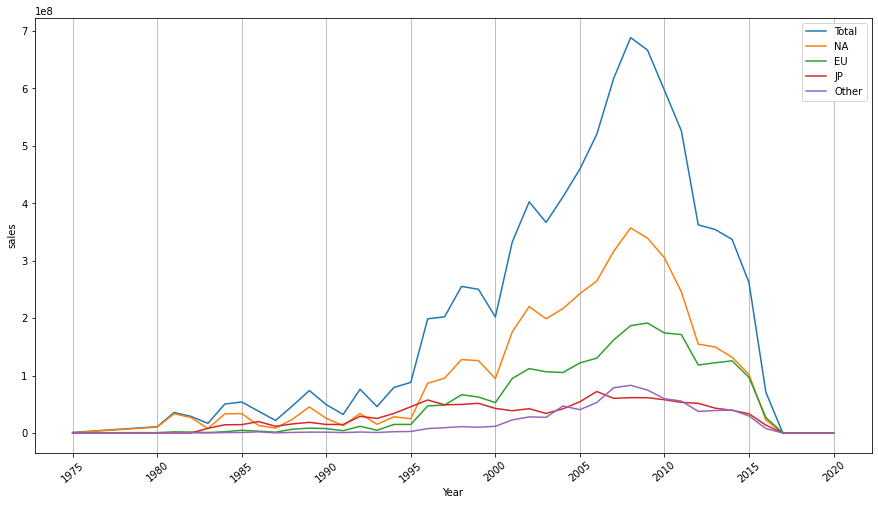

In [21]:
# 연도별 전체 출고량
plt.figure(figsize=(15,8))
sns.lineplot(data=total, x='Year',y='TotalSales', label='Total')
sns.lineplot(data=total, x='Year',y='NA_Sales', label='NA')
sns.lineplot(data=total, x='Year',y='EU_Sales', label='EU')
sns.lineplot(data=total, x='Year',y='JP_Sales', label='JP')
sns.lineplot(data=total, x='Year',y='Other_Sales', label='Other')

plt.xticks([y for y in range(total['Year'].min(),total['Year'].max()+1,5)],rotation=40)
plt.ylabel("sales")
plt.legend(loc='best')
plt.grid(True,axis='x')

In [81]:
total[total['Year']>=2010].describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,TotalSales,NA_Sales_ratio,EU_Sales_ratio,JP_Sales_ratio,Other_Sales_ratio
count,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.00000,10.000000,10.000000,10.000000
mean,2014.600000,1.112000e+08,8.353900e+07,2.926900e+07,2.694300e+07,2.509510e+08,46.92500,25.765000,19.008000,8.302000
std,3.204164,1.077263e+08,7.050784e+07,2.362648e+07,2.327790e+07,2.228647e+08,25.95899,14.890459,29.076117,4.576065
min,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+04,0.00000,0.000000,0.000000,0.000000
25%,2012.250000,5.867500e+06,6.697500e+06,3.455000e+06,1.952500e+06,1.792750e+07,38.95500,19.800000,9.807500,7.672500
50%,2014.500000,1.168950e+08,1.076150e+08,3.644500e+07,3.363500e+07,2.994550e+08,42.47500,32.610000,11.960000,10.480000
75%,2016.750000,1.534600e+08,1.247775e+08,4.956500e+07,3.979250e+07,3.602975e+08,50.02000,36.390000,13.887500,11.015000
max,2020.000000,3.050200e+08,1.741600e+08,5.787000e+07,5.962000e+07,5.966700e+08,93.10000,37.780000,100.000000,11.870000


In [83]:
total[(total['Year']>=2000) & (total['Year']<2010)].describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,TotalSales,NA_Sales_ratio,EU_Sales_ratio,JP_Sales_ratio,Other_Sales_ratio
count,10.00000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000,10.000000
mean,2004.50000,2.426100e+08,1.264300e+08,5.098100e+07,4.668300e+07,4.667040e+08,51.908000,27.093000,11.651000,9.348000
std,3.02765,8.009441e+07,4.298029e+07,1.258005e+07,2.525274e+07,1.563732e+08,2.193707,1.390748,3.674868,2.502549
min,2000.00000,9.470000e+07,5.287000e+07,3.405000e+07,1.164000e+07,2.019800e+08,46.890000,25.050000,8.930000,5.760000
25%,2002.25000,2.033225e+08,1.055900e+08,4.218500e+07,2.741000e+07,3.756250e+08,50.970000,26.197500,9.410000,7.067500
50%,2004.50000,2.313150e+08,1.170650e+08,4.857500e+07,4.381500e+07,4.353550e+08,52.285000,26.840000,10.380000,9.520000
75%,2006.75000,3.034050e+08,1.541250e+08,6.112750e+07,6.932250e+07,5.931250e+08,52.910000,28.365000,11.787500,11.382500
max,2009.00000,3.570100e+08,1.913900e+08,7.219000e+07,8.302000e+07,6.883600e+08,54.670000,29.060000,21.180000,12.750000


In [94]:
y2000 = '{:.20f}'.format(4.667040e+08)
y2010 = '{:.20f}'.format(2.509510e+08)
print(format(float(y2000),','))
print(format(float(y2010),','))

(float(y2000) - float(y2010)) / float(y2000)

466,704,000.0
250,951,000.0


0.4622908738729473

- 전체 출고량을 살펴 보았을 때, 1995년을 기점으로 상승세 2009년을 기점으로 하락
  - 2000~2009년 전체 출고량 평균 약 466,704,000 개
  - 2010년 이후 전체 출고량 평균 약 250,951,000 개
  - 2010년 이후의 총 출고량은 2000~2009년을 기준으로 약 47% 감소
- 북미(North America)와 유럽(EU)지역의 출고량은 전체 출고량의 약 51%, 20%를 차지
  - 출고량의 70%는 북미(North America)와 유럽(EU)지역에서 발생

In [24]:
# 장르별 출고 비율
genre_cnt = df.reset_index().groupby(['Genre'])['index'].count().sort_values(ascending=False)
total_cnt = df.shape[0]
genre_ratio = (genre_cnt / total_cnt) * 100
genre_ratio = pd.DataFrame(genre_ratio).rename({'index':'ratio'},axis=1).reset_index()


In [27]:
genre_ratio[:5]

,Genre,ratio
0,Action,20.023134
1,Sports,14.209181
2,Misc,10.331182
3,Role-Playing,8.997930
4,Shooter,7.883843


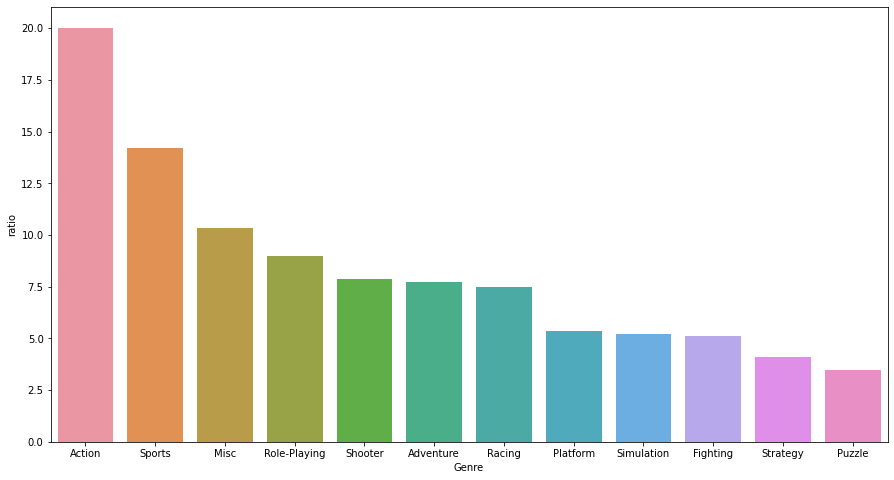

In [28]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=genre_ratio,
            x = 'Genre',
            y = 'ratio')


- 장르별 전체 출고량은 Action, Sports, Misc  순서로 높음

---
<H3> 출고량 기준 </H3>

- 2010년 이후로 보았을 때, 게임 시장이 하락세에 있는 듯 보임
  - 사전 시장 조사 필요해 보임
- 출고량만 보았을 때, 북미(North America), 유럽(EU) 지역이 높은 출고량을 보인다.
- 출고량 기준으로 Action, Sports 출시가 유리해 보임


---
#### 1. 지역에 따라 선호하는 게임 장르가 다를까

그럼, 지역에 따라 선호하는 게임의 장르가 다를까? <br/>
만얃 지역별로 선호 장르 게임이 다르다면, 지역별로 인기있는 장르가 무엇인지 알아보자. 


In [34]:
# 장르별 지역에 따른 출고량 차이 보기

genre_region_total = df.groupby(['Genre'])\
                      ['NA_Sales','EU_Sales','JP_Sales','Other_Sales','TotalSales']\
                      .sum().reset_index()

genre_region_mean = df.groupby(['Genre'])\
                      ['NA_Sales','EU_Sales','JP_Sales','Other_Sales','TotalSales']\
                      .mean().reset_index()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


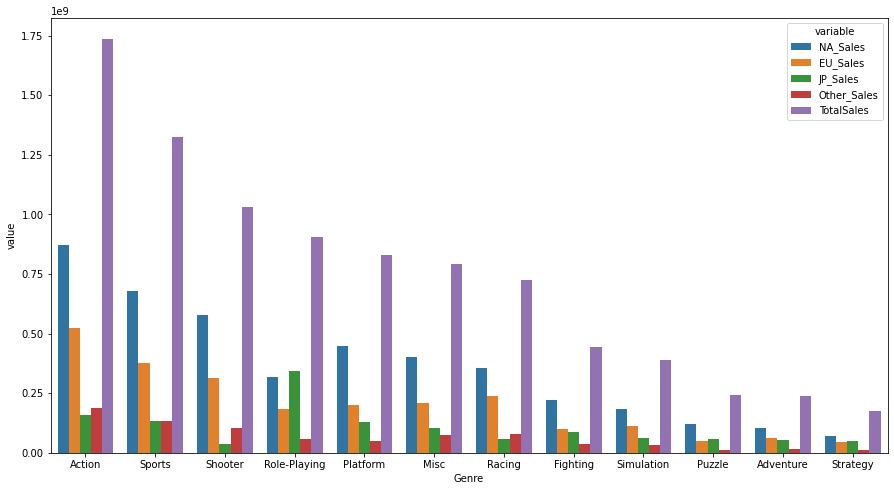

In [42]:
## 전체 출고량 N수 기준으로 본 데이터
plt.figure(figsize=(15,8))

ax = sns.barplot(data=genre_region_total.sort_values(['TotalSales'],ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


- 출고량의 합으로 장르별 지역의 차이를 살펴보았을 때, Action, Sports, Shooter 게임의 인기가 있어 보임

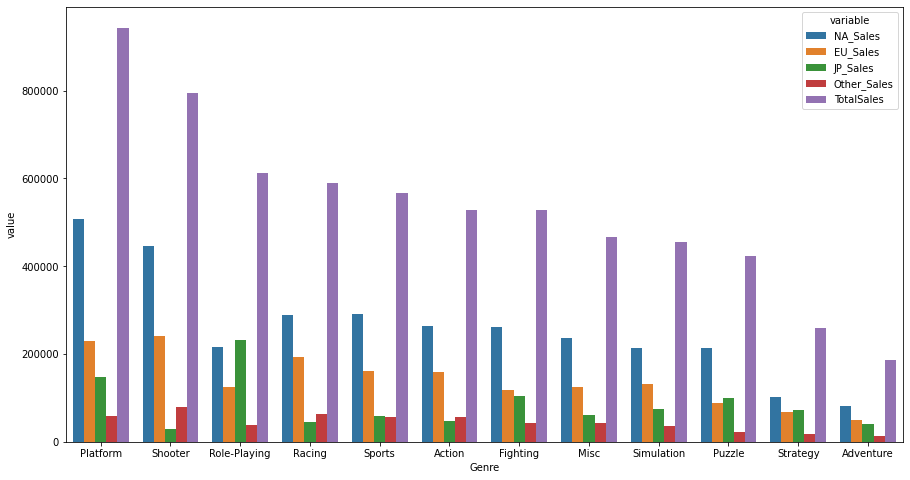

In [43]:
## 전체 출고량 N수 기준으로 본 데이터
plt.figure(figsize=(15,8))

ax = sns.barplot(data=genre_region_mean.sort_values(['TotalSales'],ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


- 출시 게임 수가 많을 경우 Total에 영향을 주었을 가능성이 있다. 때문에 게임 1개당 출고량(Mean)으로 보았을 때는 Platform, Shooter 장르가 높은 출고량을 보임
- Japan, Other 지역에서 상대적으로 출고량(빈도)가 낮은 비율을 보이기 때문에 지역 내에서 장르에 따른 선호도를 보기 어려움

In [118]:
column = genre_region_mean.columns[genre_region_mean.columns.str.contains('_Sales')]
genre_region_ratio = pd.DataFrame(genre_region_mean['Genre'].unique(),
                                  columns=['Genre'])
for c in columns:
  ratio = (genre_region_mean.set_index('Genre')[c] / genre_region_mean[c].sum() * 100)\
          .reset_index()\
          .rename({0:c}, axis=1)

  genre_region_ratio = genre_region_ratio.merge(ratio,
                           how='left',
                           left_on='Genre',
                           right_on='Genre')

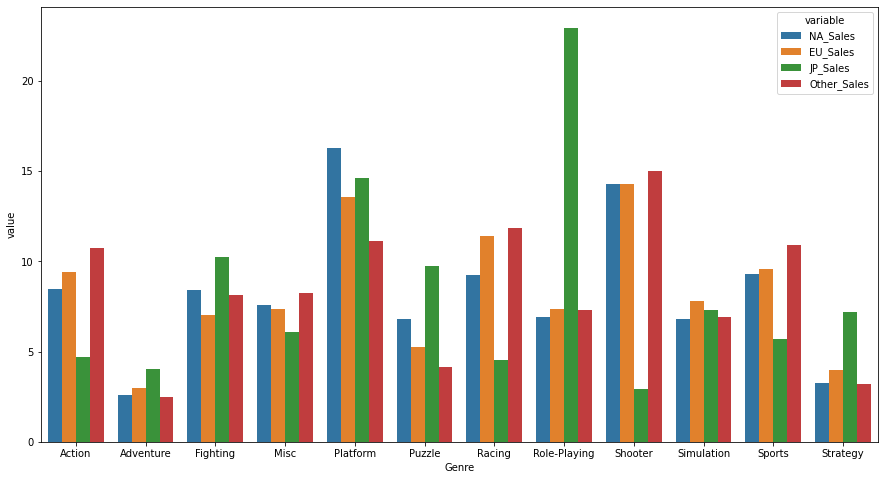

In [119]:
## 전체 출고량 N수 기준으로 본 데이터
plt.figure(figsize=(15,8))

ax = sns.barplot(data=genre_region_ratio.melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')




- Mean을 기준으로 지역별로 각 장르가 어느정도 비율을 보이는지 살펴봄
  - 육안으로 보았을 때는 지역별 차이가 느껴지지 않음
  - 다만, Japan의 Role-Playing 장르가 타 지역 뿐 아니라 이볼 내에서도 높은 출고량을 보이고 있음
  

In [164]:
data = df[df['Genre']==g].melt(id_vars='Genre')
data = data[data['variable'].isin(region)]
data

,Genre,variable,value
2700,Strategy,NA_Sales,10000.0
2701,Strategy,NA_Sales,0.0
2702,Strategy,NA_Sales,300000.0
2703,Strategy,NA_Sales,0.0
2704,Strategy,NA_Sales,220000.0
...,...,...,...
5395,Strategy,Other_Sales,60000.0
5396,Strategy,Other_Sales,30000.0
5397,Strategy,Other_Sales,10000.0
5398,Strategy,Other_Sales,10000.0


##### 가설 검정 
1-1. 지역 별로 장르의 선호도 차이가 있을까? 


Action
                  df        sum_sq       mean_sq           F         PR(>F)
C(variable)      3.0  1.024313e+14  3.414378e+13  237.560904  4.054199e-150
Residual     13152.0  1.890290e+15  1.437264e+11         NaN            NaN
---------------------------
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
 group1     group2     meandiff   p-adj     lower        upper     reject
-------------------------------------------------------------------------
EU_Sales    JP_Sales -110778.3521  0.001 -134798.4149  -86758.2892   True
EU_Sales    NA_Sales  106321.0702  0.001   82301.0074  130341.1331   True
EU_Sales Other_Sales  -101979.325  0.001 -125999.3879  -77959.2622   True
JP_Sales    NA_Sales  217099.4223  0.001  193079.3595  241119.4852   True
JP_Sales Other_Sales    8799.0271 0.7569  -15221.0358   32819.0899  False
NA_Sales Other_Sales -208300.3953  0.001 -232320.4581 -184280.3324   True
-----------------------------------------------------------------------

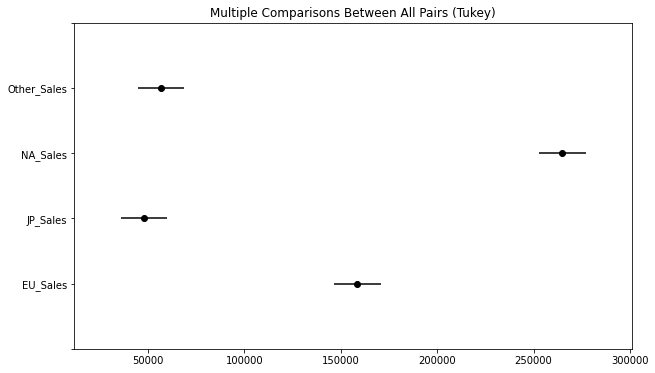

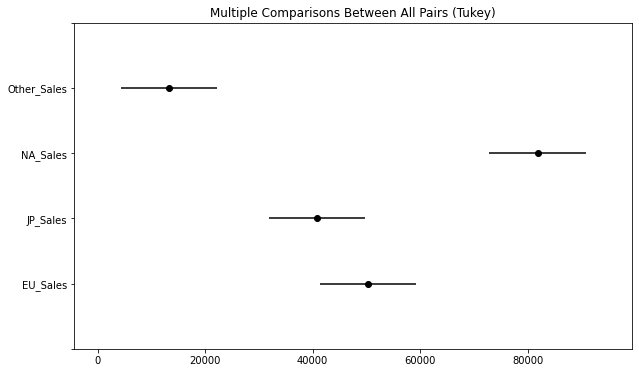

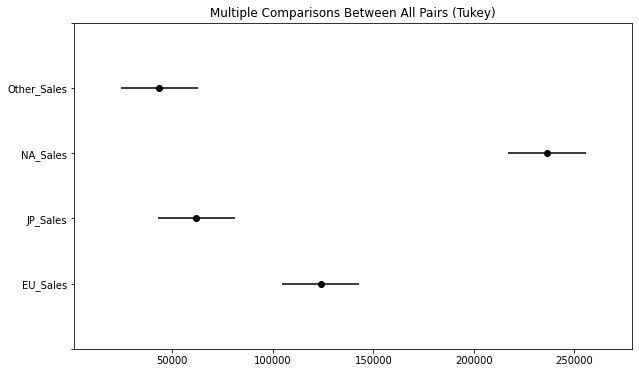

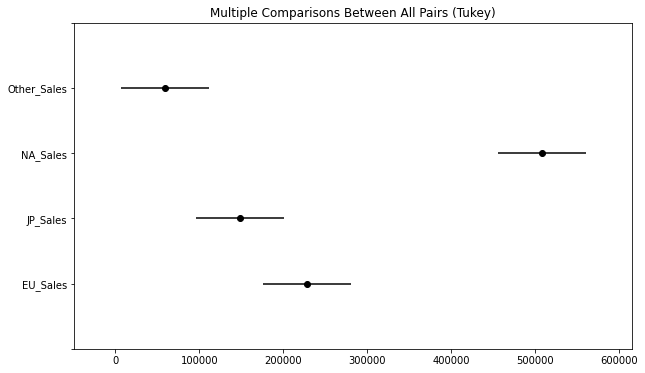

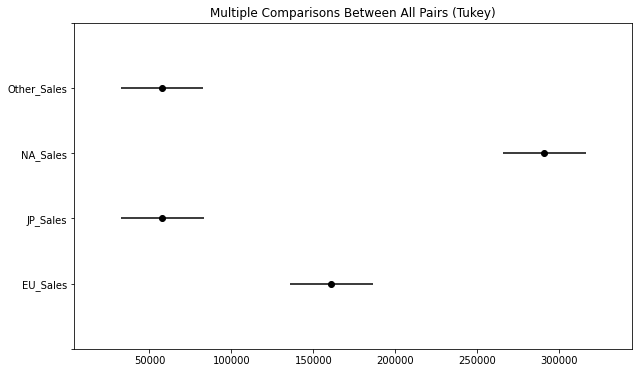

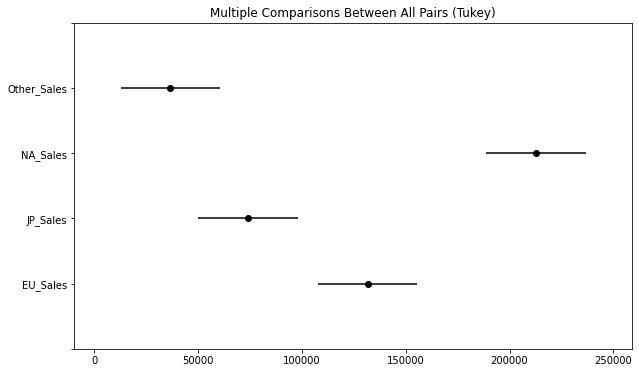

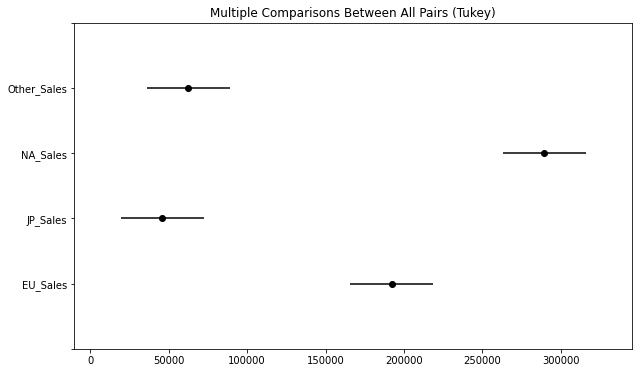

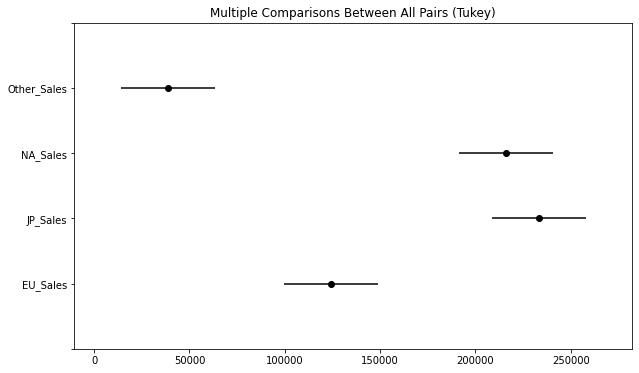

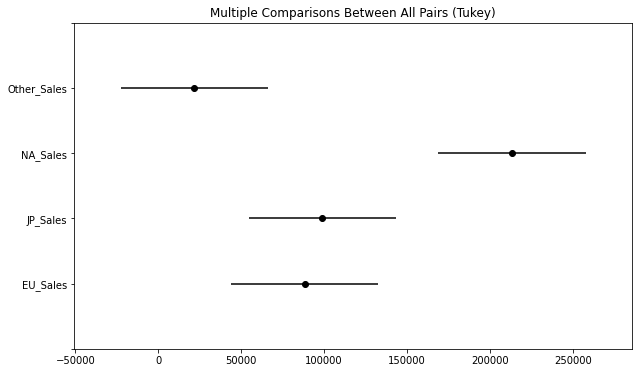

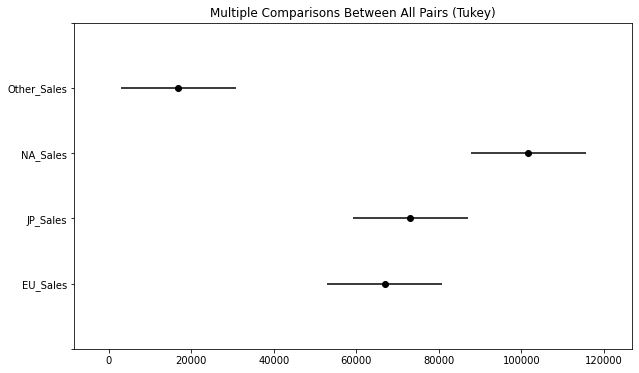

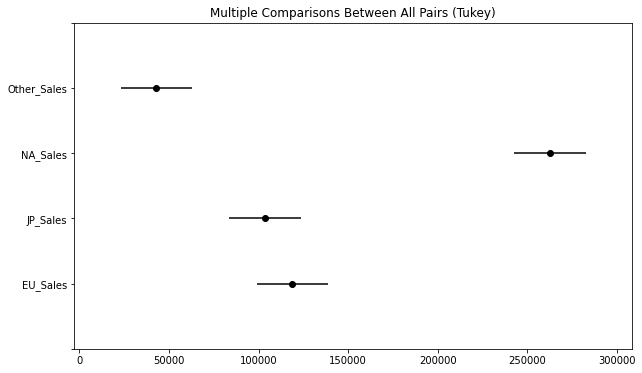

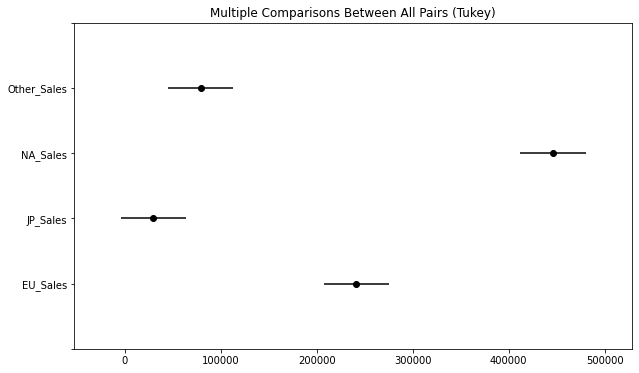

In [191]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

genre = df['Genre'].unique()
region = df.columns[df.columns.str.contains('_Sales')]
for g in genre:
  cond = (df['Genre']==g)
  data = df[df['Genre']==g].melt(id_vars='Genre')
  data = data[data['variable'].isin(region)][['variable','value']]
  data['value'] =  data['value'].astype(float)
  # na = data[cond]['NA_Sales']
  # eu = data[cond]['EU_Sales']
  # jp = data[cond]['JP_Sales']
  # other = data[cond]['Other_Sales']

  model = ols('value ~ C(variable)',data).fit()
  print(g)
  print(anova_lm(model))
  print("---------------------------")
  posthoc = pairwise_tukeyhsd(data['value'], data['variable'], alpha=0.05)
  print(posthoc)
  fig = posthoc.plot_simultaneous()


H0 : 장르에 따라 지역별 차이가 없다<br/>
H1 : 장르에 따라 지역별 차이가 있다<br/>

- 귀무가설 기각
- 장르에 따라 지역별 차이는 유의미한 차이이다. 

1-2. 장르 별로 선호 정도는 지역에 따라 차이가 있을까? 

In [190]:

print("Action",'{:.20f}'.format(4.054199e-150))
print("Adventure ",'{:.20f}'.format(3.498456e-21))
print("Misc ",'{:.20f}'.format(6.104199e-43))
print("Platform ",'{:.20f}'.format(1.110416e-28))
print("Sports ",'{:.20f}'.format(1.636539e-40))
print("Simulation ",'{:.20f}'.format(1.051730e-21))
print("Racing ",'{:.20f}'.format(1.424081e-39))
print("Role-playing ",'{:.20f}'.format(3.492841e-28))
print("Puzzle ",'{:.20f}'.format(7.020761e-07))
print("Strategy ",'{:.20f}'.format(1.513427e-13))
print("Fighting ",'{:.20f}'.format(1.088940e-44))
print("Shooter ",'{:.20f}'.format(1.494537e-63))


Action 0.00000000000000000000
Adventure  0.00000000000000000000
Misc  0.00000000000000000000
Platform  0.00000000000000000000
Sports  0.00000000000000000000
Simulation  0.00000000000000000000
Racing  0.00000000000000000000
Role-playing  0.00000000000000000000
Puzzle  0.00000070207610000000
Strategy  0.00000000000015134270
Fighting  0.00000000000000000000
Shooter  0.00000000000000000000


NA_Sales
               df        sum_sq       mean_sq          F        PR(>F)
C(Genre)     11.0  1.660500e+14  1.509546e+13  22.824757  4.031035e-47
Residual  16414.0  1.085562e+16  6.613634e+11        NaN           NaN
---------------------------
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
   group1       group2      meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------------
      Action    Adventure -183120.5911  0.001 -270887.8587  -95353.3235   True
      Action     Fighting   -2533.3961    0.9 -105197.2703  100130.4781  False
      Action         Misc  -28580.3323    0.9 -108028.0295   50867.3648  False
      Action     Platform  242779.3649  0.001  141850.4707  343708.2591   True
      Action       Puzzle  -51745.0789    0.9 -171986.0583   68495.9006  False
      Action       Racing   24423.1584    0.9  -64365.6029  113211.9196  False
      Action Role-Playing  -48770.5111 

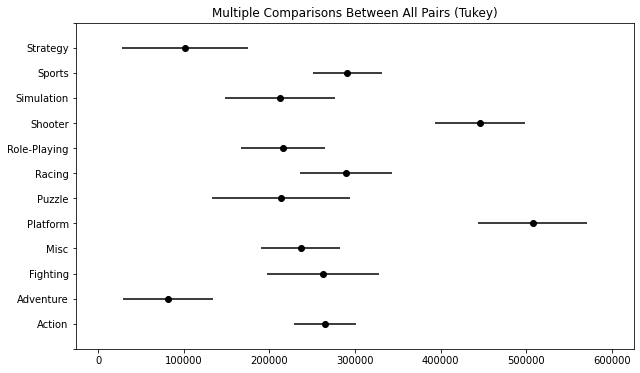

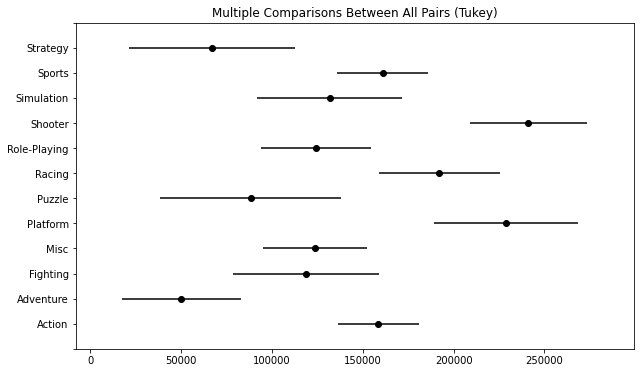

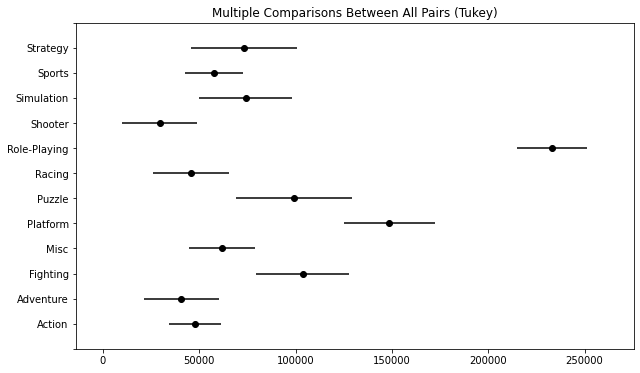

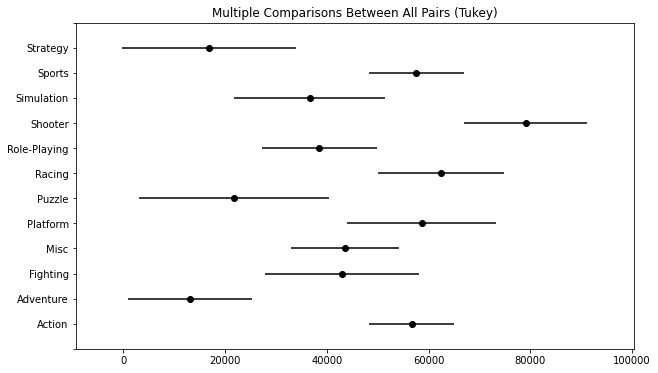

In [192]:
genre = df['Genre'].unique()
region = df.columns[df.columns.str.contains('_Sales')]
for r in region:
  data = df[['Genre',r]]
  
  # na = data[cond]['NA_Sales']
  # eu = data[cond]['EU_Sales']
  # jp = data[cond]['JP_Sales']
  # other = data[cond]['Other_Sales']
  
  model = ols(r+' ~ C(Genre)',data).fit()
  print(r)
  print(anova_lm(model))
  print("---------------------------")
  posthoc = pairwise_tukeyhsd(data[r], data['Genre'], alpha=0.05)
  print(posthoc)
  fig = posthoc.plot_simultaneous()


In [153]:
print("NA: ",'{:.20f}'.format(4.031035e-47))
print("EU: ",'{:.20f}'.format(3.392268e-29))
print("JP: ",'{:.20f}'.format(8.081793e-111))
print("Other :",'{:.20f}'.format(1.783793e-24))

NA:  0.00000000000000000000
EU:  0.00000000000000000000
JP:  0.00000000000000000000
Other : 0.00000000000000000000


H0 : 지역에 따라 장르별 차이가 없다<br/>
H1 : 지역에 따라 장르별 차이가 있다<br/>

- 귀무가설 기각
- 지역에 따라 장르별 차이는 유의미한 차이이다. 

#### 2. 연도별 게임의 트렌드가 있을까


###### 장르별 출시된 게임의 수는 연도에 따른 차이가 있을까

In [193]:
# 연도별 출시된 장르 개수

genreBYyear = pd.DataFrame(df.reset_index()\
                            .groupby(['Year_binning','Genre'])['index']\
                            .count()\
                            .reset_index())
genreBYyear.rename({'index':'Freq'},axis=1,inplace=True) 
genreBYyear.sort_values(by=['Year_binning','Freq'], ascending=[True,False],inplace=True)

# Year_binning 별 장르 비율 확인하기
Year_Total = genreBYyear.groupby(['Year_binning'])['Freq'].sum()

genreBYyear = genreBYyear.merge(Year_Total,how='left',
                  on=['Year_binning'])
genreBYyear['ratio'] = genreBYyear['Freq_x'] / genreBYyear['Freq_y'] * 100 
genreBYyear.drop('Freq_y',axis=1,inplace=True) 
genreBYyear.rename({'Freq_x':'Freq'},inplace=True)

In [215]:
freq

Year_binning,1980~1989,1990~1999,2000~2009,2010~
Genre,,,,
Action,67,162,1605,1455
Adventure,3,97,634,538
Fighting,5,193,448,196
Misc,9,115,1005,568
Platform,33,126,569,151
Puzzle,19,72,364,119
Racing,8,181,805,238
Role-Playing,9,171,739,559
Shooter,31,137,728,399


In [216]:
# 연도별 출시 게임 수
freq = pd.crosstab(df['Genre'],df['Year_binning'])
column = freq.columns
ratio = pd.DataFrame()
for i in range(len(freq.columns)-1):
  ratio[column[i+1]] = ((freq.iloc[:,(i+1)] - freq.iloc[:,(i)]) / freq.iloc[:,(i)]) * 100

ratio

,1990~1999,2000~2009,2010~
Genre,,,
Action,141.791045,890.740741,-9.345794
Adventure,3133.333333,553.608247,-15.141956
Fighting,3760.000000,132.124352,-56.250000
Misc,1177.777778,773.913043,-43.482587
Platform,281.818182,351.587302,-73.462214
Puzzle,278.947368,405.555556,-67.307692
Racing,2162.500000,344.751381,-70.434783
Role-Playing,1800.000000,332.163743,-24.357240
Shooter,341.935484,431.386861,-45.192308


In [217]:
ratio['2000~2009'].mean()

445.39547817085304

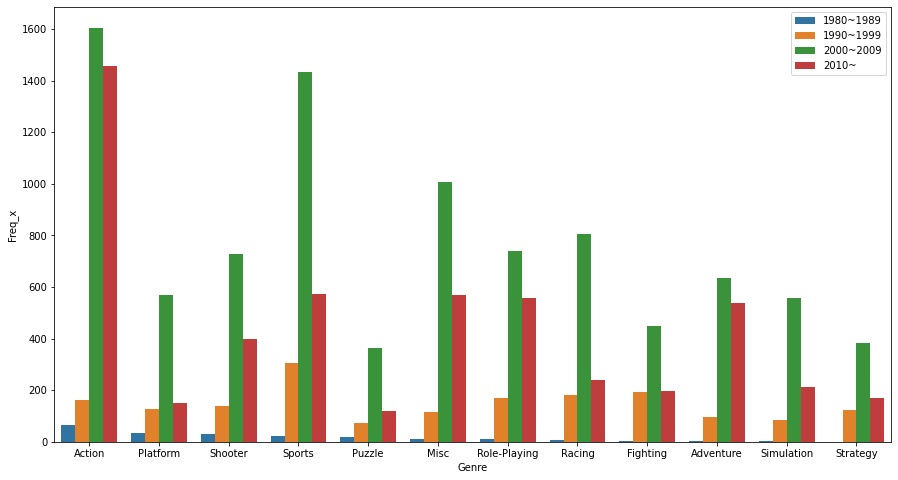

In [194]:
# 연도 별 장르에 따른 게임 출시 수
data = genreBYyear.groupby(['Year_binning','Genre'])['Freq_x']\
        .sum()\
        .reset_index()\
        .sort_values(by=['Year_binning','Freq_x'],ascending=[True,False])


plt.figure(figsize=(15,8))
ax = sns.barplot(data=data,
                 x='Genre', y='Freq_x', hue='Year_binning',
                  )
plt.legend(loc='upper right')


- 게임 출시 수를 보면, 2000년도 이후 게임 출시량이 높아짐 그 비율은 1990년도 기준 평균 445.39% 상승 <br/>
- 특히 Action, Sports 장르에서 높은 출시량을 보이고 있음

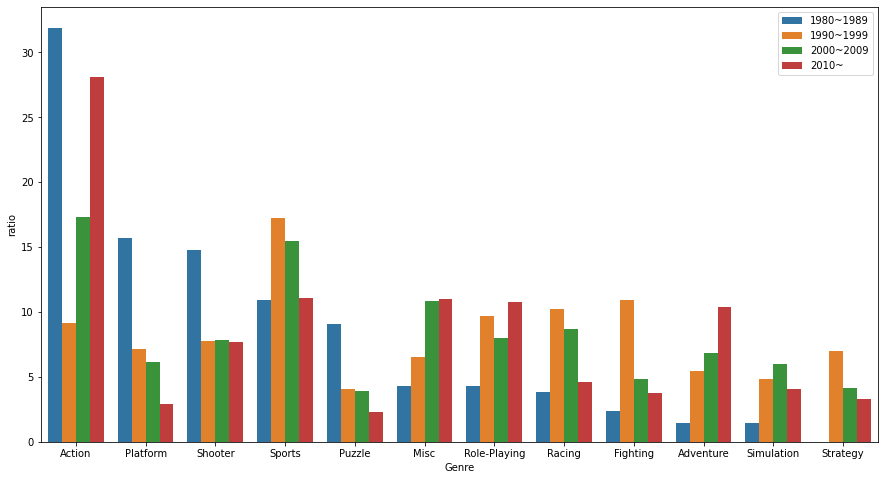

In [133]:
# 연도 별 장르에 따른 게임 출시 비율

data = genreBYyear.groupby(['Year_binning','Genre'])['ratio']\
        .sum()\
        .reset_index()\
        .sort_values(by=['Year_binning','ratio'],ascending=[True,False])


plt.figure(figsize=(15,8))
ax = sns.barplot(data=data,
                 x='Genre', y='ratio', hue='Year_binning',
                  )
plt.legend(loc='upper right')
# plt.title("Sales by Genre ")


- 게임 출시 수를 각 연도별 비율로 확인해보았을 때,
  - Action은 다른 장르보다 출시 비율이 높음
  - Platform, Puzzle 장르의 출시는 꾸준한 하락세를 보임
  - Role-Playing, Adventure 장르는 지속적인 상승세


##### 연도별 장르의 출고량 기준으로 확인해보자.

In [364]:
salesBYyear = pd.DataFrame(df.reset_index()\
                            .groupby(['Year_binning','Genre'])['TotalSales']\
                            .sum()\
                            .reset_index())
# salesBYyear.rename({'index':'Freq'},axis=1,inplace=True) 
salesBYyear.sort_values(by=['Year_binning','TotalSales'], ascending=[True,False],inplace=True)

# Year_binning 별 장르 비율 확인하기
Year_Total = salesBYyear.groupby(['Year_binning'])['TotalSales'].sum()

salesBYyear = salesBYyear.merge(Year_Total,how='left',
                  on=['Year_binning'])
salesBYyear['ratio'] = round(salesBYyear['TotalSales_x'] / salesBYyear['TotalSales_y'] * 100 ,2)
salesBYyear.drop('TotalSales_y',axis=1,inplace=True) 
salesBYyear.rename({'TotalSales_x':'TotalSales'},inplace=True)


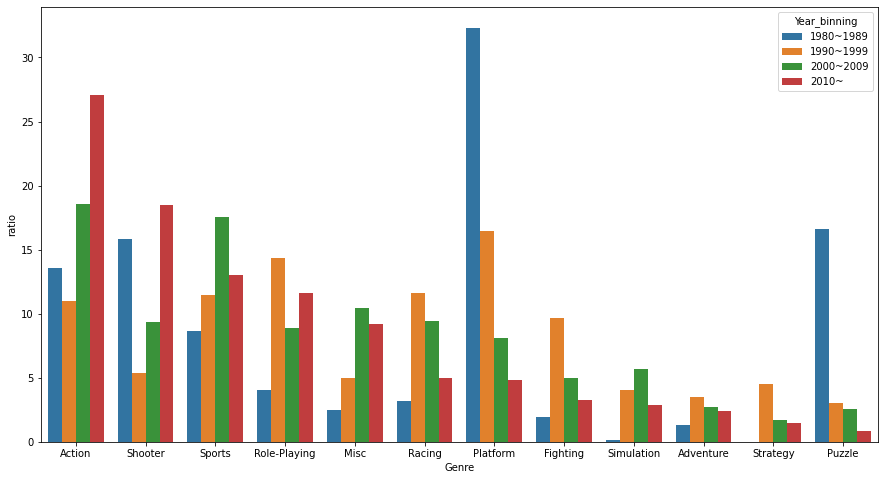

In [365]:
# 연도별 장르의 출고량 비율

plt.figure(figsize=(15,8))
ax = sns.barplot(data=salesBYyear.sort_values(by=['Year_binning','ratio'],ascending=[False,False]),
                 x='Genre', y='ratio', hue='Year_binning')


- 연도별 장르의 출고 비율을 보면 출시 게임수와 비슷한 결과를 보임
- Platform ~ Puzzle 까지 하위 7개의 장르는 지속적인 출고량 하락
  - 특히 Platform, Puzzle의 출고량은 급격한 하락을 보임 
- Action ~ Misc 의 상위 5개 브랜드의 경우 소폭이지만 상승폭을 보임

Text(0, 0.5, 'TotalSales')

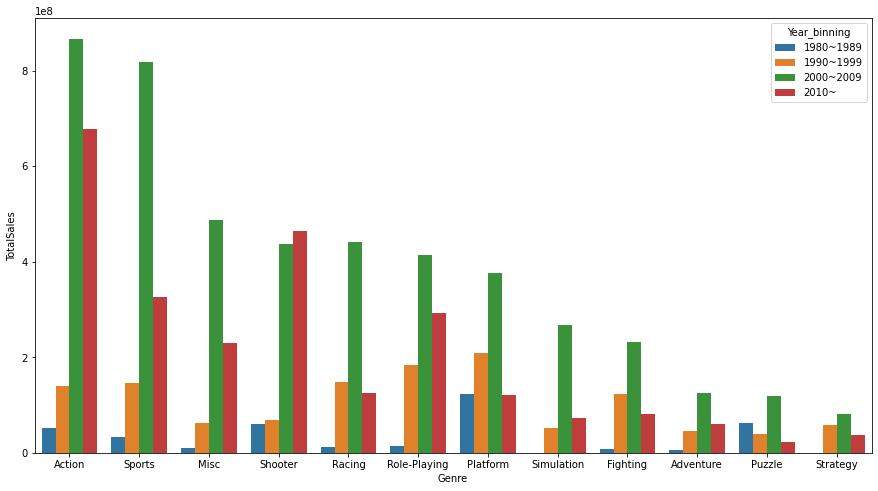

In [366]:
## 장르별 출고량
plt.figure(figsize=(15,8))
ax = sns.barplot(data=salesBYyear.sort_values('TotalSales_x', ascending=False),
                 x='Genre', y='TotalSales_x', hue='Year_binning')
plt.ylabel("TotalSales")

- 게임 출고량을 기준으로 보았을 때도 연도별 출고 비율과 큰 차이를 보이지 않음

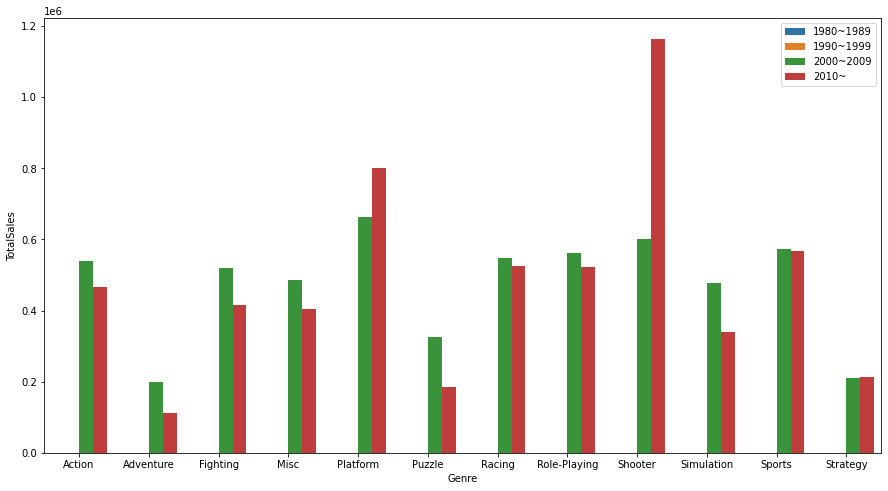

In [157]:
## 2000년대 이후 기준으로
plt.figure(figsize=(15,8))
ax = sns.barplot(data=salesBYyear_mean[salesBYyear_mean['Year_binning'].isin(['2000~2009','2010~'])],
                 x='Genre', y='TotalSales', hue='Year_binning')
plt.legend(loc='upper right')

In [149]:
df.groupby(['Year_binning'])['TotalSales'].describe()

,count,mean,std,min,25%,50%,75%,max
Year_binning,,,,,,,,
1980~1989,210.0,1.801048e+06,4.319481e+06,10000.0,382500.0,830000.0,1520000.0,40240000.0
1990~1999,1768.0,7.225962e+05,1.620029e+06,10000.0,110000.0,270000.0,690000.0,31380000.0
2000~2009,9269.0,5.035106e+05,1.581049e+06,0.0,60000.0,170000.0,460000.0,82740000.0
2010~,5179.0,4.845549e+05,1.217753e+06,10000.0,50000.0,140000.0,410000.0,21820000.0


In [158]:
df.groupby(['Year_binning','Genre'])['TotalSales'].min().unstack()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year_binning,,,,,,,,,,,,
1980~1989,20000.0,80000.0,170000.0,230000.0,510000.0,60000.0,270000.0,760000.0,10000.0,30000.0,70000.0,NaN
1990~1999,10000.0,10000.0,10000.0,10000.0,20000.0,20000.0,10000.0,20000.0,20000.0,20000.0,10000.0,10000.0
2000~2009,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,0.0,10000.0,10000.0,10000.0,10000.0,10000.0
2010~,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0


In [160]:
df.groupby(['Year_binning','Genre'])['TotalSales'].median().unstack()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year_binning,,,,,,,,,,,,
1980~1989,400000.0,400000.0,1050000.0,1050000.0,1230000.0,1100000.0,1350000.0,1250000.0,1000000.0,40000.0,1420000.0,NaN
1990~1999,315000.0,130000.0,250000.0,200000.0,570000.0,295000.0,300000.0,320000.0,160000.0,305000.0,300000.0,180000.0
2000~2009,210000.0,75000.0,195000.0,160000.0,210000.0,100000.0,180000.0,180000.0,180000.0,160000.0,220000.0,80000.0
2010~,160000.0,35000.0,180000.0,130000.0,230000.0,70000.0,170000.0,150000.0,400000.0,105000.0,200000.0,80000.0


In [152]:
df.groupby(['Year_binning','Genre'])['TotalSales'].max().unstack()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year_binning,,,,,,,,,,,,
1980~1989,6500000.0,4380000.0,3020000.0,2140000.0,40240000.0,30260000.0,4160000.0,3870000.0,28310000.0,440000.0,4000000.0,NaN
1990~1999,7600000.0,11180000.0,7180000.0,5310000.0,20620000.0,4840000.0,10950000.0,31380000.0,8090000.0,5110000.0,5020000.0,5450000.0
2000~2009,20810000.0,5550000.0,13040000.0,29010000.0,30010000.0,15300000.0,35830000.0,18350000.0,13520000.0,24750000.0,82740000.0,2740000.0
2010~,21390000.0,3230000.0,7440000.0,21820000.0,10790000.0,2680000.0,12210000.0,15320000.0,14760000.0,9100000.0,8490000.0,4830000.0


Action


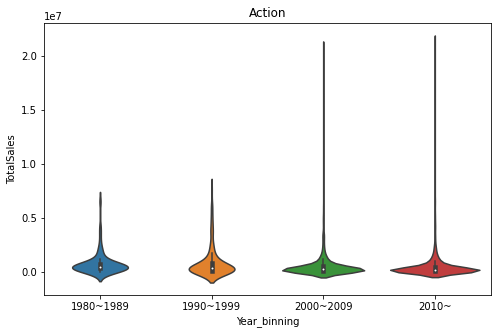

Sports


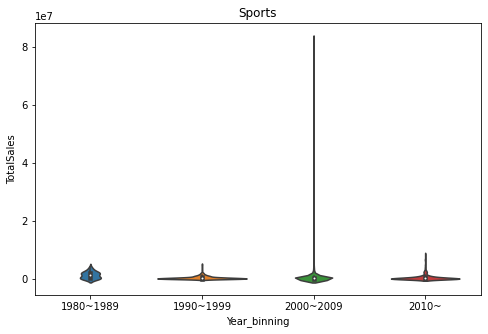

Role-Playing


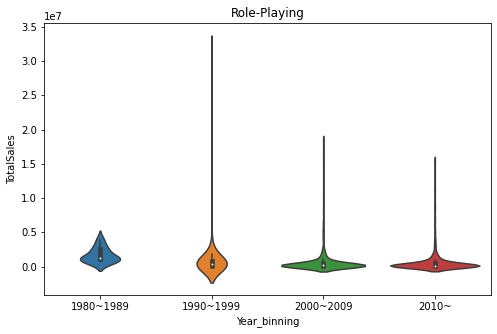

Shooter


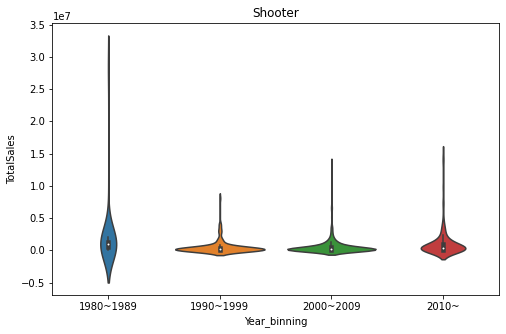

In [21]:
# plt.hist(df[df['Year_binning']=='2000~2009' & df['Genre']=='Action'].TotalSales)

year = df['Year_binning'].unique()
genre = ['Action','Sports','Role-Playing','Shooter']
for g in genre:
  print(g)
  plt.figure(figsize=(8,5))
  # for y in year:  
    # ax = sns.violinplot(data = df[(df['Year_binning']==y) & (df['Genre']==g)],
    #                     x='')
  ax = sns.violinplot(data = df[(df['Genre']==g)],
                        x='Year_binning',
                        y='TotalSales')
  plt.title(g,)
  plt.show()    

- Action 장르의 경우 높은 출고량을 보이는 이상치들이 있어 평균에 영향을 주었을 것으로 보임
- Shooter 장르는 다른 장르에 비해 이상치가 낮음

---
Action 장르의 출고량, 게임출시로 보았을 때, 인기가 높은듯해 보였지만, 데이터의 분포에서 이상치의 영향이 있었음
다음으로 높은 인기를 끌었던 Shooter 장르의 경우 다른 장르보다 이상치가 적지만 상대적으로 높은 출고량, 출시를 보였기 때문에 안정적일 것이라 생각

##### 3. 출고량이 높은 게임에 대한 분석 및 시각화

##### Top100 살펴보기

##### 1. 전체기준 

In [172]:
top100 = df.sort_values('TotalSales',ascending=False)[:100]
top100.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,TotalSales,Year_binning
2908,Wii Sports,Wii,2006,Sports,Nintendo,41490000.0,29020000.0,3770000.0,8460000.0,82740000.0,2000~2009
4199,Super Mario Bros.,NES,1985,Platform,Nintendo,29080000.0,3580000.0,6810000.0,770000.0,40240000.0,1980~1989
12579,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000.0,12880000.0,3790000.0,3310000.0,35830000.0,2000~2009
3352,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000.0,11010000.0,3280000.0,2960000.0,33000000.0,2000~2009
7829,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11270000.0,8890000.0,10220000.0,1000000.0,31380000.0,1990~1999


In [248]:

## TOP 100 내 장르별 개수 BY 2010년 이후
total_2010 = df.loc[df['Year_binning']=='2010~',:].sort_values(['TotalSales'],ascending=False)
top100_2010 = df.loc[df['Year_binning']=='2010~',:].sort_values(['TotalSales'],ascending=False)[:100]

No handles with labels found to put in legend.


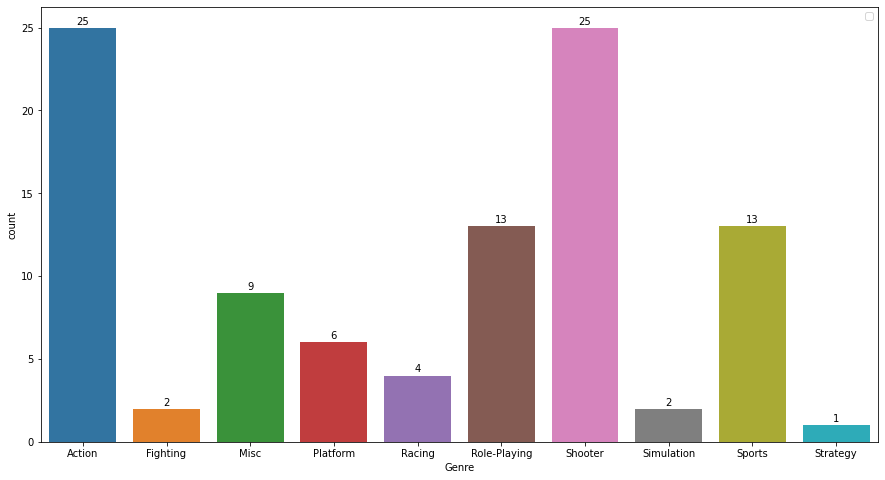

In [249]:
# Top 100 
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Genre',
              data=top100_2010,
              order=['Action', 'Fighting', 'Misc', 'Platform', 'Racing', 'Role-Playing',
       'Shooter', 'Simulation', 'Sports', 'Strategy'])

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.2, height,
          ha = 'center', size=10)  
plt.legend(loc='upper right')


Top 100 에 들어온 장르별 개수를 확인해보았다. <br/>
Action, Shooter 장르가 각각 25개 씩 차지하고 있다 


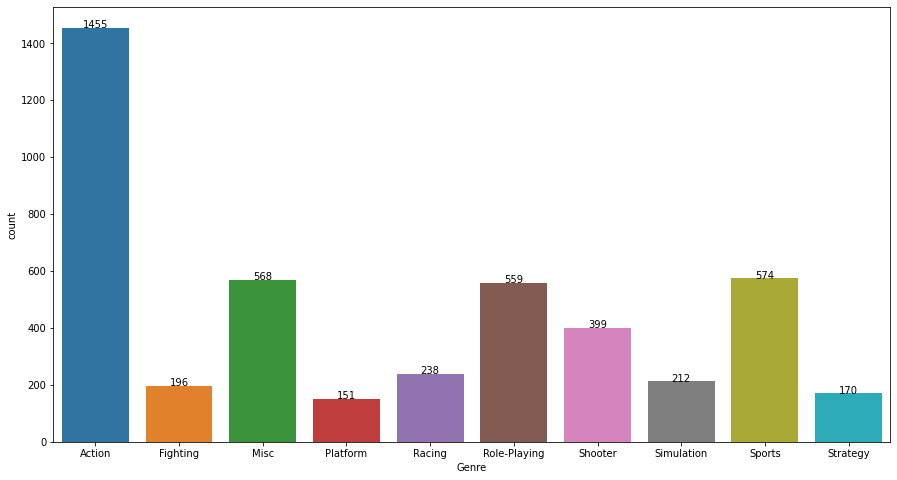

In [250]:
# 전체 

plt.figure(figsize=(15,8))
ax = sns.countplot(x='Genre',
              data=total_2010,
              order=['Action', 'Fighting', 'Misc', 'Platform', 'Racing', 'Role-Playing',
       'Shooter', 'Simulation', 'Sports', 'Strategy'])

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.2, height,
          ha = 'center', size=10)
  


In [251]:
## 전체 장르별 출고량 비율
total_2010_grouped = total_2010.reset_index().groupby(['Genre'])['index'].count().reset_index()
top100_2010_grouped = top100_2010.reset_index().groupby(['Genre'])['index'].count().reset_index()
top100_2010_grouped = total_2010_grouped.merge(top100_2010_grouped, on='Genre')
top100_2010_grouped['ratio'] = round(top100_2010_grouped['index_y'] / top100_2010_grouped['index_x'] * 100,2)

No handles with labels found to put in legend.


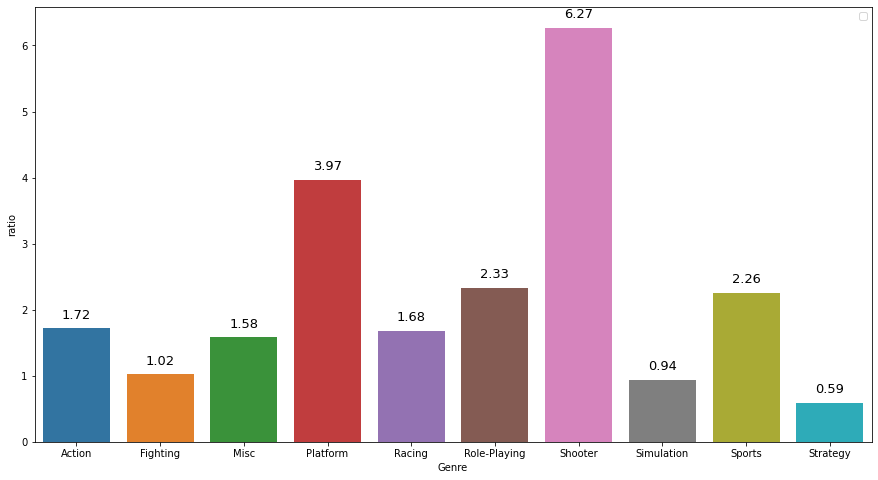

In [252]:

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Genre',
              y='ratio',
              data=top100_2010_grouped)

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x()+p.get_width()/ 2.,
          height+0.15, height,
          ha='center',
          size=13)
  
plt.legend(loc='upper right')


- 2010년 이후 기준으로 Action, Shooter 는 각 25개씩 Top100에 위치
  - Top100의 절반이 Action과 Shooter 
- 전체 출시 수 대비 Top100 내에 들어온 비율로 보았을 때, Shooter, Platform 이 각각 6.27%, 3.97%로 높음
- Action 장르는 전체 출시 수에 비해 낮은 비율로 Top 100에 위치

In [345]:
## 지역별 연도별 장르 선호도 -> 출고량 기준

# 전체, 지역별 출고량 Mean 가져오기
# 해당 코드 사용 X
def region(r):

  region_sum = top100_2010.groupby('Genre')[r].sum() # SUM 기준 
  region_mean = top100_2010.groupby(['Genre'])[r].mean() # Mean 기준
  total = top100_2010.groupby('Genre')[r].mean().sum()

  return pd.DataFrame(region_mean), pd.DataFrame(round((region_mean / total) * 100,2)), pd.DataFrame(region_sum)

top100_region_sum = pd.DataFrame(top100_2010['Genre'].unique(), columns=['Genre'])
top100_region_ratio = pd.DataFrame(top100_2010['Genre'].unique(), columns=['Genre'])
top100_region_mean = pd.DataFrame(top100_2010['Genre'].unique(), columns=['Genre'])

sales = top100_2010.columns[top100_2010.columns.str.contains('Sales')]

for r in sales:
  
  mean, ratio, sum = region(r)
  
  ratio.sort_values(ascending=False,inplace=True, by=[r])

  # 장르별 선호 비율
  top100_region_ratio = top100_region_ratio.merge(ratio,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=ratio.index)
  
  top100_region_mean = top100_region_mean.merge(mean,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=mean.index)
  
  top100_region_sum = top100_region_sum.merge(sum,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=sum.index)
  


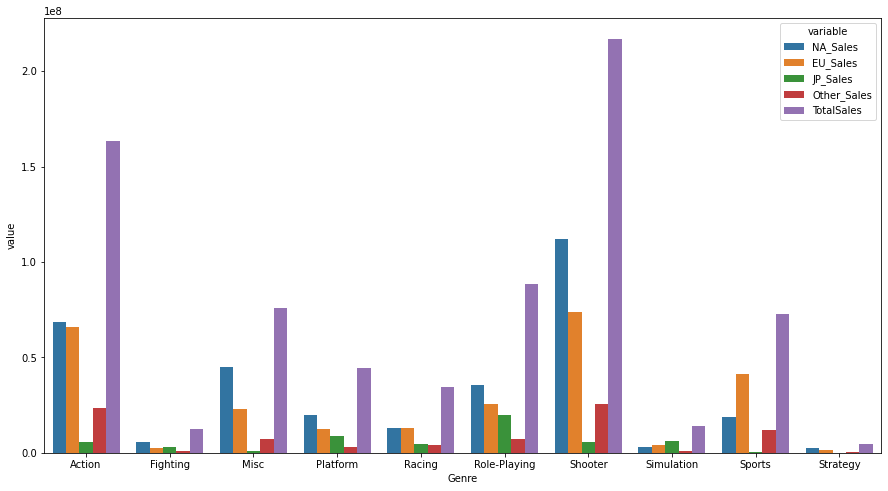

In [346]:
# Top100 지역별 출고 합계
plt.figure(figsize=(15,8))
ax = sns.barplot(data=top100_region_sum.sort_values('Genre').melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')

plt.show()


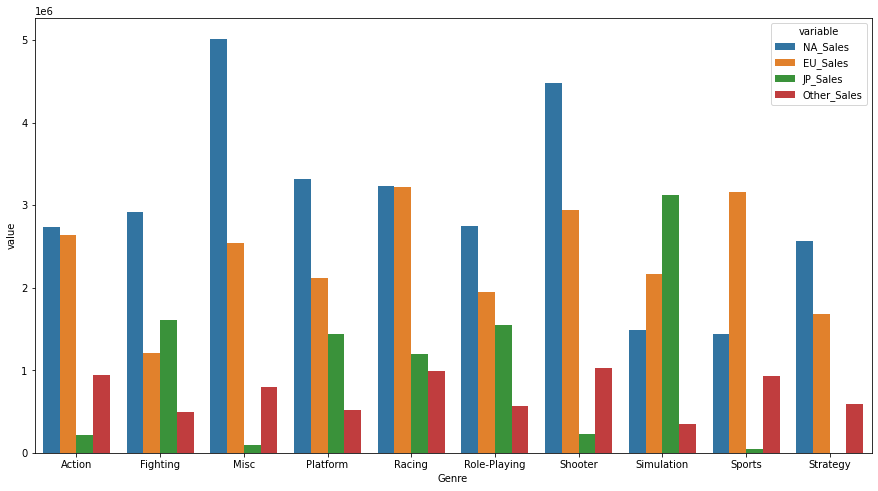

In [309]:
# Top100 지역별 출고 평균
plt.figure(figsize=(15,8))
ax = sns.barplot(data=top100_region_mean.sort_values('Genre').melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')

plt.show()


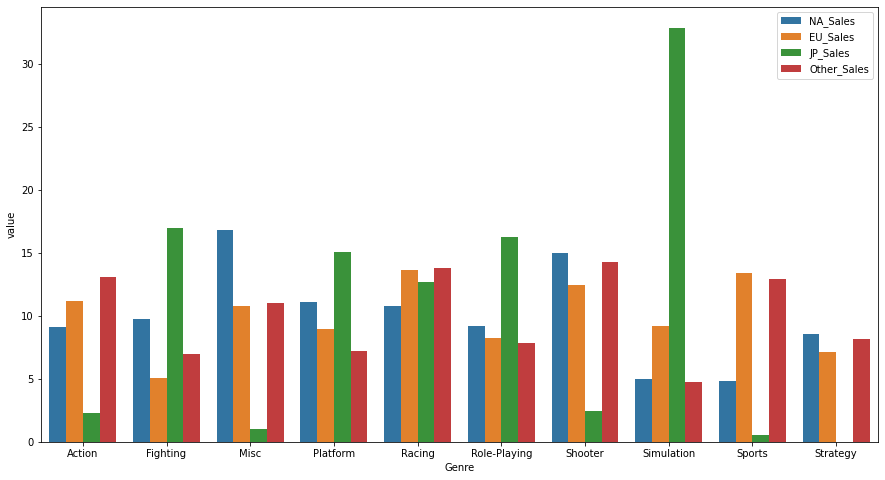

In [310]:
# Top100 지역별 출고 비율
plt.figure(figsize=(15,8))
ax = sns.barplot(data=top100_region_ratio.sort_values('Genre').melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')
plt.legend(loc='upper right')
plt.show()



- 전체 출고량과 동일하게 TOP100 출고량 또한 북미와 유럽 지역에서 대부분을 차지
- 이례적으로 Simulation 장르는 북미, 유럽 지역보다 Japan 지역에서 많은 양이 출고
- Shooter, Action 장르의 경우 전체적인 출고량은 높지만 Japan 지역에서는 큰 인기를 끌지 못함

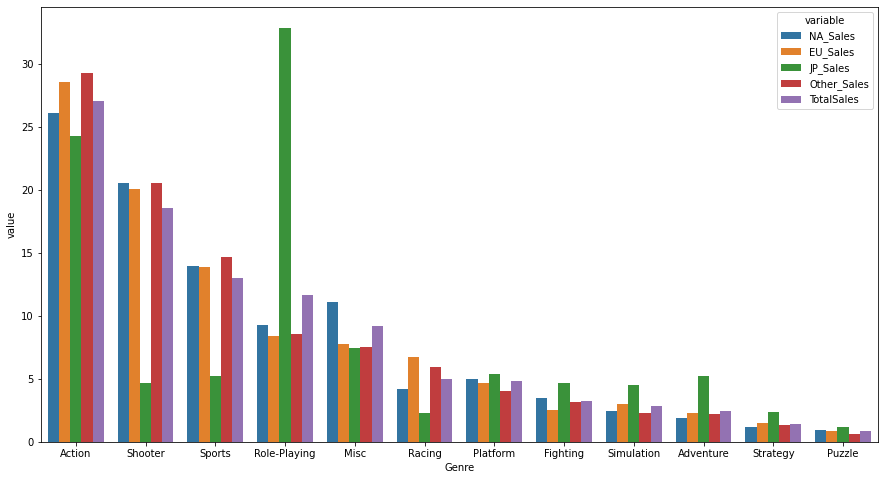

In [385]:
## 지역별 장르에 따라 출고된 비율
plt.figure(figsize=(15,8))
ax = sns.barplot(data=releaseBYregion_2010_ratio.sort_values('TotalSales',ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


#### 2010 년 이후 데이터를 기준으로 장르별 지역에 따른 출고량 차이

In [379]:
# 전체, 지역별 출고량 Mean 가져오기
# 해당 코드 사용 X
def sales(r):
  cond = (df['Year_binning']=='2010~')
  genre_sum = df[cond].groupby('Genre')[r].sum() # SUM 기준 
  genre_mean = df[cond].groupby('Genre')[r].mean() # Mean 기준
  total = df[cond].groupby('Genre')[r].sum().sum()
  # total = df[cond].groupby('Genre')[r].mean().sum()
  return pd.DataFrame(genre_mean), pd.DataFrame(round((genre_sum / total) * 100,2)), pd.DataFrame(genre_sum)


releaseBYregion_2010_ratio = pd.DataFrame(df['Genre'].unique(),
                     columns=['Genre'])
releaseBYregion_2010_mean = pd.DataFrame(df['Genre'].unique(),
                     columns=['Genre'])
releaseBYregion_2010_sum = pd.DataFrame(df['Genre'].unique(),
                     columns=['Genre'])

region = df.columns[df.columns.str.contains('Sales')]
for r in region:
  mean, ratio, sum = sales(r)
  
  ratio.sort_values(ascending=False,inplace=True, by=[r])

  # 장르별 선호 비율
  releaseBYregion_2010_ratio = releaseBYregion_2010_ratio.merge(ratio,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=ratio.index)
  
  releaseBYregion_2010_mean = releaseBYregion_2010_mean.merge(mean,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=mean.index)
  
  releaseBYregion_2010_sum = releaseBYregion_2010_sum.merge(sum,
                                                      how='left',
                                                      left_on='Genre',
                                                      right_on=sum.index)
  
  # 7순위 이후의 데이터는 Others로 묶어서 좀
  # others = pd.DataFrame([ratio[r][7:].sum()],
  #                       columns=[r],
  #                       index=['Others'])

  # ratio = pd.concat([ratio[:7],others])
  

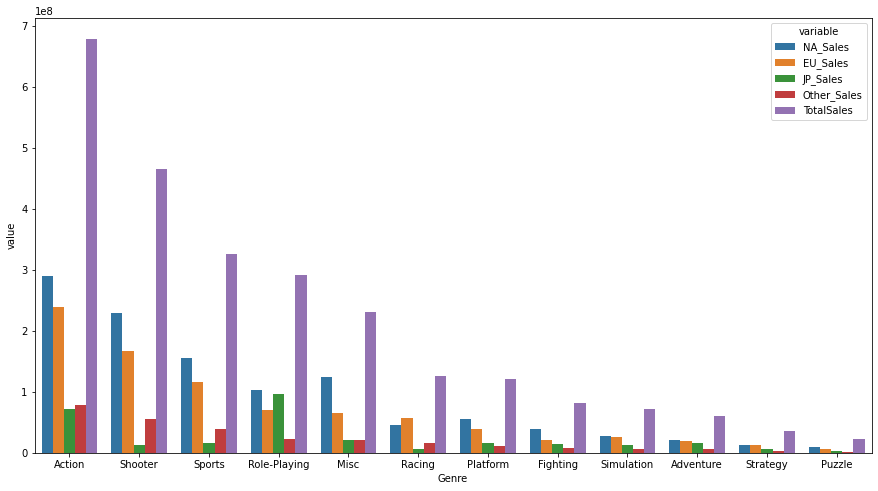

In [373]:
## 전체 출고량 N수 기준으로 본 데이터
plt.figure(figsize=(15,8))

ax = sns.barplot(data=releaseBYregion_2010_sum.sort_values('TotalSales',ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


- 전체 출고량으로 보았을 떄, Action 이 가장 높은 출고량을 보이고 있음

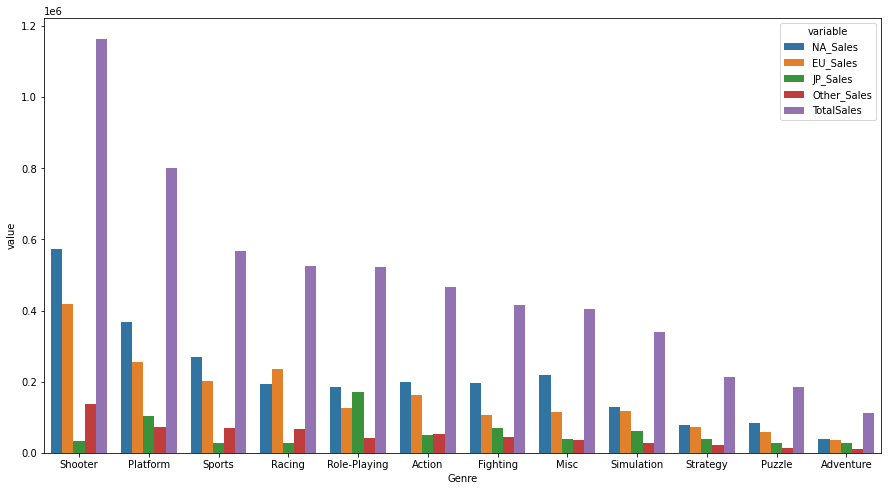

In [380]:
## 지역별 장르에 따른 게임 1개당 출고량
plt.figure(figsize=(15,8))
ax = sns.barplot(data=releaseBYregion_2010_mean.sort_values('TotalSales',ascending=False).melt(id_vars='Genre'),
            x = 'Genre',
            y = 'value',
            hue = 'variable')


- 지역별 2010년 이후 데이터로 출고량 비율을 확인해 보았을 때,
  - Shooter, Platform, Sports 장르가 북미, 유럽지역에서 인기가 높은 것으로 보여짐
    - Actions 의 높은 출고량은 게임수가 많아서 나온 결과로 보여지며, 평균으로 보았을 때, 높은 비율을 보이지 않음 
  - Platform의 경우 높은 출고 비율을 보여주지만, 현재 시장 게임 출시가 감소하고 전체 출고량도 감소세를 보이고 있어 추천하지 않음
  - 일본 지역의 경우 Role-Playing 이 높은 비율을 가지고 있음

### 장르와 플랫폼은 관계가 있을까?
- H0 : 장르와 플랫폼은 관계가 없다.
- H1 : 장르와 플랫폼은 관계가 있다.


In [317]:
import scipy.stats as stats

In [318]:
genre_platform = pd.crosstab(df['Genre'],df['Platform'])
stats.chi2_contingency(observed=genre_platform)

(5838.549378277951,
 0.0,
 330,
 array([[2.32268355e+01, 6.00694022e-01, 1.01317058e+02, 1.04120297e+01,
         4.29095763e+02, 1.96226714e+01, 1.58182759e+02, 1.10727931e+02,
         5.40624620e+00, 2.00231341e-01, 6.30728723e+01, 1.96226714e+01,
         2.40277609e+00, 1.89218617e+02, 2.00231341e-01, 2.38075064e+02,
         4.30697614e+02, 2.63304213e+02, 6.70774991e+01, 2.41478997e+02,
         8.20948496e+01, 3.46400219e+01, 1.20138804e+00, 4.78552904e+01,
         4.00462681e-01, 1.20138804e+00, 2.61902593e+02, 2.86330817e+01,
         2.50889870e+02, 1.63789237e+02, 4.24490442e+01],
        [8.98283210e+00, 2.32314623e-01, 3.91837331e+01, 4.02678680e+00,
         1.65950079e+02, 7.58894436e+00, 6.11761841e+01, 4.28233289e+01,
         2.09083161e+00, 7.74382077e-02, 2.43930354e+01, 7.58894436e+00,
         9.29258493e-01, 7.31791063e+01, 7.74382077e-02, 9.20740290e+01,
         1.66569585e+02, 1.01831243e+02, 2.59417996e+01, 9.33904785e+01,
         3.17496652e+01, 1.3396809

- P-value = 0.0, 귀무가설 기각, 대립가설 채택 
- 플랫폼과 장르간에 차이가 존재한다. 

### 연도와 플랫폼은 관계가 있을까?
- H0 : 연도와 플랫폼은 관계가 없다.
- H1 : 연도와 플랫폼은 관계가 있다.


In [319]:
year_platform = pd.crosstab(df['Year_binning'],df['Platform'])
stats.chi2_contingency(observed=year_platform)

(33449.40514668394,
 0.0,
 90,
 array([[1.48301473e+00, 3.83538293e-02, 6.46901254e+00, 6.64799708e-01,
         2.73974187e+01, 1.25289176e+00, 1.00998417e+01, 7.06988920e+00,
         3.45184464e-01, 1.27846098e-02, 4.02715208e+00, 1.25289176e+00,
         1.53415317e-01, 1.20814562e+01, 1.27846098e-02, 1.52009010e+01,
         2.74996956e+01, 1.68117618e+01, 4.28284427e+00, 1.54182394e+01,
         5.24169000e+00, 2.21173749e+00, 7.67076586e-02, 3.05552173e+00,
         2.55692195e-02, 7.67076586e-02, 1.67222696e+01, 1.82819920e+00,
         1.60191160e+01, 1.04578108e+01, 2.71033727e+00],
        [1.24855717e+01, 3.22902715e-01, 5.44629246e+01, 5.59698040e+00,
         2.30660173e+02, 1.05481554e+01, 8.50310483e+01, 5.95217338e+01,
         2.90612444e+00, 1.07634238e-01, 3.39047851e+01, 1.05481554e+01,
         1.29161086e+00, 1.01714355e+02, 1.07634238e-01, 1.27977109e+02,
         2.31521247e+02, 1.41539023e+02, 3.60574699e+01, 1.29806892e+02,
         4.41300377e+01, 1.86207232

- P-value = 0.0, 귀무가설 기각, 대립가설 채택 
- 플랫폼과 연도간에 관계가 있다. 

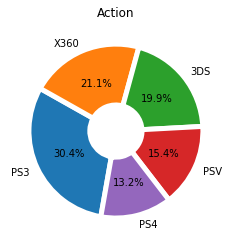

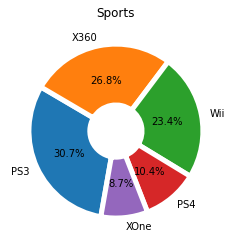

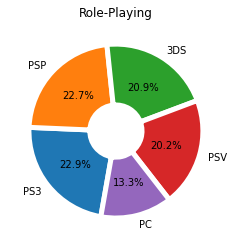

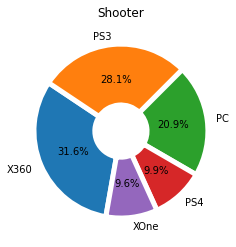

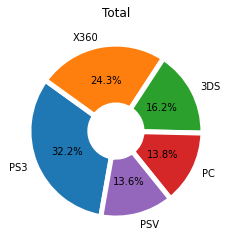

In [322]:
data = df[(df['Year_binning']=='2010~') & (df['Genre'].isin(['Action','Shooter','Sports','Role-Playing']))]

genre_platform = pd.DataFrame(data.reset_index().groupby(['Genre','Platform'])['index'].count()).reset_index()
genre_platform.rename({'index':'Freq'},axis=1,inplace=True)
genre = data['Genre'].unique()
for g in genre:
  cond = (genre_platform['Genre']==g)
  genre_top5 = genre_platform[cond].groupby(['Platform'])['Freq'].sum().sort_values(ascending=False)[:5].reset_index()
  wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
  plt.pie(genre_top5['Freq'], labels=genre_top5['Platform'],startangle=260, autopct='%1.1f%%',counterclock=False, wedgeprops=wedgeprops)
  
  plt.title(g)
  plt.show()

total_platform = pd.DataFrame(data.reset_index().groupby(['Platform'])['index'].count().sort_values(ascending=False)[:5]).reset_index()
total_platform.rename({'index':'Freq'},axis=1,inplace=True)
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(total_platform['Freq'], labels=total_platform['Platform'],startangle=260, autopct='%1.1f%%',counterclock=False, wedgeprops=wedgeprops)
plt.title("Total")
plt.show()



- 검증을 통해 장르별 플랫폼, 연도별 플랫폼은 서로 차이가 있음을 확인
- 2010년 이후 데이터를 기준으로 장르별 출시된 플랫폼 종류 확인
  - Action : PS3 or X360
  - Shooter : X360 or PS3
  - Role-Playing : PS3 or PSP

No handles with labels found to put in legend.


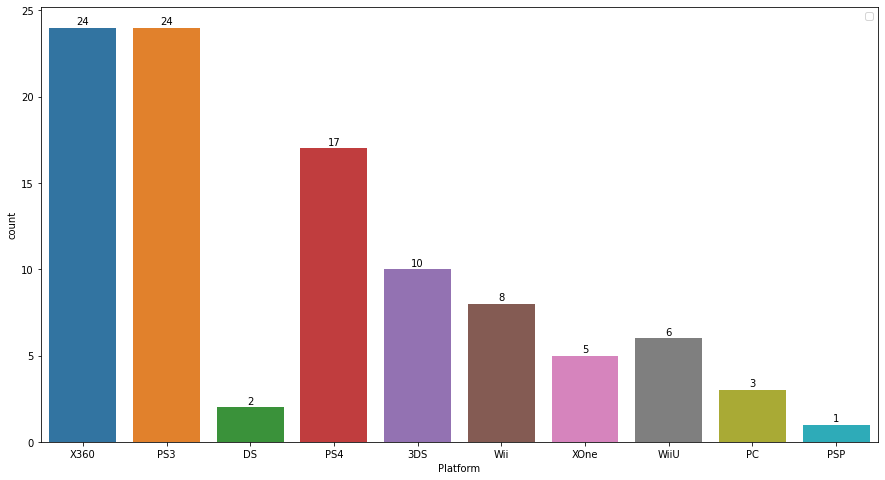

In [347]:

## TOP 100 내 장르별 개수 
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Platform',
              data=top100_2010)

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.2, height,
          ha = 'center', size=10)
plt.legend(loc='upper right')

# sns.countplot()


<h1> 결론 </h1>

- 지역
  - 특정 지역에 출시를 해야한다면 출고량이 높았던 북미(North America) 또는 유럽(EU) 출시를 추천
  - 일본(Japan) 지역의 경우 다른 지역들과 선호 장르에 차이를 보이고 있음

- 장르
  - 북미(North America)와 유럽(EU) 지역에서는 전체적으로 인기 였던 Shooter 추천
    - Action 장르는 시대를 가리지 어느정도 인기에 있지만, 게임 시장이 커서 경쟁이 심할 것으로 보임
  - 일본 지역 한정으로 출시할 경우, Role-Playing, Simulation을 추천
  - 다른 장르로 출시할 계획에 있을 경우, Puzzle, Platform 장르는 비 추천
    - Platform 의 경우 전체 비율로 보았을 때 상위권에 속해 있지만, 시간이 흐를수록 그 인기가 감소하고 있음.

- 플랫폼
 - Action : PS3 or X360
 - Shooter : X360 or PS3
 - Role-Playing : PS3 or PSP